In [1]:
import csv
# import cv2
# import os
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import graphviz
from keras_visualizer import visualizer


# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Input, Conv2D, Concatenate, MaxPooling2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )
from keras.engine import  Model

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers 


# imaging
import cv2
import imgaug
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from ann_visualizer.visualize import ann_viz;



path = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Redesigned/'

tf.__version__: 2.4.1
keras.__version__: 2.4.0


In [3]:
yy = []
xx = []

with open('train_flip_correct.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
#     print(reader)
    with open('training_norm_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
#         c = 0
        for rows in reader:
#             if c > 100:
#                 break
            f = rows[0]
            a = float(rows[1])
            s = float(rows[2])
            yy.append([a, s])
            filename = str(f)
            xx.append(filename)
            

In [6]:
directory_annotations = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Redesigned/'
x_names=[]
y=[]
for file in os.listdir(directory_annotations):
    if file == '.DS_Store' or file == '.DS_S.xml' or file.split('.')[1] == '.csv':
        continue
    
    if '_' in file:
        f=(file.split('_')[0])
    else:
        f=(file.split('.')[0])
    x_names.append(file)
    y.append(yy[xx.index(f)])

In [7]:
print(np.size(x_names))

38860


In [8]:
print(np.shape(y))

(38860, 2)


In [9]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training, shuffle=True):
    num_batches = int(np.floor(len(image_paths) / batch_size))
    bc = 0
#     print('bc ', bc)
    indexes = np.arange(len(image_paths))
    if shuffle == True:
            np.random.shuffle(indexes)
    while True:
        batch_images = []
        batch_steering_angles = []
        x1 = []
        x2 = []
        path = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Redesigned/'
        
        for i in range(batch_size):
            index = bc * batch_size + i  
#             print('bc, i, index, indexes, is_training = ', bc, i, index, indexes[index], is_training)
            image_path = path + image_paths[indexes[index]]
            image = cv2.imread(image_path)
            steering_angle = steering_angles[indexes[index]]
#             if is_training:
#                 # training: augment image
#                 image, steering_angle = random_augment(image, steering_angle)
              
            images = img_preprocess(image)
            x1.append(images[0])
            x2.append(images[1])
            batch_steering_angles.append(steering_angle)
        bc += 1 
        if bc >= num_batches:
            bc = 0
            if shuffle == True:
                np.random.shuffle(indexes)  
            
        yield( [np.asarray(x1), np.asarray(x2)], np.asarray(batch_steering_angles))

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split( x_names, y, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 31088
Validation data: 7772


In [11]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

In [12]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

In [13]:

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

In [14]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [15]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle[0] = 1 - steering_angle[0] # (80 - steering_angle[0]*80)/80
        #(180 - (steering_angle[0]*80 + 50) -50)/80
   
    return image, steering_angle

In [16]:
def random_augment(image, steering_angle):
#     if np.random.rand() < 0.5:
#         image = pan(image)
#     if np.random.rand() < 0.5:
#         image = zoom(image)
#     if np.random.rand() < 0.5:
#         image = blur(image)
#     if np.random.rand() < 0.5:
#         image = adjust_brightness(image)
#     image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

In [17]:
def img_preprocess(image):
    height, _, _ = image.shape
    image1 = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 
    image1 = cv2.resize(image1, (160,60)) # input image size (200,66) Nvidia model
    image1 = image1 / 255
    
    image2 = cv2.resize(image, (160,120))
    image2 = image2 / 255
    return [image1, image2]

In [2]:
# Model Speed
inp_speed = Input(shape=(120, 160, 3), name='M1_L1')
x1 = Conv2D(32, (5, 5), strides=(2, 2), activation='elu')(inp_speed)
x1 = Conv2D(32, (5, 5), strides=(2, 2), activation='elu')(x1)
# x = MaxPooling2D(pool_size=(3, 3),strides=2)(x)
# x2 = Dropout(0.2)(x2)
x1 = Conv2D(48, (5, 5), activation='elu')(x1)
x1 = Conv2D(48, (5, 5), activation='elu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2),strides=2)(x1)

x1 = Conv2D(64, (3, 3), activation='elu')(x1)
x1 = Conv2D(64, (3, 3), activation='elu')(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2),strides=2)(x1)
# x = Dropout(0.3)(x)
x1 = Flatten()(x1)
x1d = Dropout(0.3)(x1)
x1 = Dense(256, activation='elu')(x1d)
x1 = Dense(100, activation='elu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(50, activation='elu')(x1)
x1 = Dense(10, activation='elu')(x1)
# x = BatchNormalization()(x)
out_speed = Dense(1, activation='sigmoid', name='speed')(x1) 


# Angle Model
inp_ang = Input(shape=(60, 160, 1))
x = Conv2D(32, (5, 5), strides=(2, 2), activation='elu')(inp_ang)
x = Conv2D(32, (5, 5), strides=(2, 2), activation='elu')(x)
# x = MaxPooling2D(pool_size=(2, 2),strides=2)(x)
# x2 = Dropout(0.2)(x2)
# x = Conv2D(48, (5, 5), activation='elu')(x)
# x = Conv2D(48, (5, 5), activation='elu')(x)
# x = MaxPooling2D(pool_size=(2, 2),strides=2)(x)

x = Conv2D(64, (3, 3), activation='elu')(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2),strides=2)(x)
# x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Concatenate()([x, x1d])
x = Dense(256, activation='elu')(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(50, activation='elu')(x)
x = Dense(10, activation='elu')(x)
# x = BatchNormalization()(x)
out_ang = Dense(1, activation='sigmoid', name='angle')(x) 
out = Concatenate()([out_ang, out_speed])
model = keras.Model(inputs=[inp_ang, inp_speed], outputs=out)
model.summary()
optimizer = Adam(lr=1e-3) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)#, loss_weights = loss_weights )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M1_L1 (InputLayer)              [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 58, 78, 32)   2432        M1_L1[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 27, 37, 32)   25632       conv2d[0][0]                     
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 60, 160, 1)] 0                                            
______________________________________________________________________________________________

In [3]:
visualizer(model, format='png')

ValueError: Keras Visualizer: Layer not supported for visualizing

In [19]:

batch_size = 32
train_steps = int(np.floor(len(X_train) / batch_size))
valid_steps = int(np.floor(len(X_valid) / batch_size))
print(train_steps, valid_steps)

971 242


In [20]:
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = '/Users/Kamyab/Documents/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'Branched_check{epoch:04d}.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=batch_size, is_training=True),
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=batch_size, is_training=False),
                              validation_steps=valid_steps,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'Branched_model.h5'))

/Users/kamyab/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
971/971 [==============================] - 437s 448ms/step - loss: 0.5178 - val_loss: 0.9541

Epoch 00001: val_loss improved from inf to 0.95412, saving model to /Users/Kamyab/Documents/Branched_check0001.h5
Epoch 2/50
971/971 [==============================] - 411s 423ms/step - loss: 0.4326 - val_loss: 1.9382

Epoch 00002: val_loss did not improve from 0.95412
Epoch 3/50
971/971 [==============================] - 426s 439ms/step - loss: 0.4041 - val_loss: 0.4155

Epoch 00003: val_loss improved from 0.95412 to 0.41552, saving model to /Users/Kamyab/Documents/Branched_check0003.h5
Epoch 4/50
971/971 [==============================] - 432s 445ms/step - loss: 0.3888 - val_loss: 0.5743

Epoch 00004: val_loss did not improve from 0.41552
Epoch 5/50
971/971 [==============================] - 444s 458ms/step - loss: 0.3742 - val_loss: 0.3801

Epoch 00005: val_loss improved from 0.41552 to 0.38012, saving model to /Users/Kamyab/Documents/Branched_check0005.h5
Epoch 6/50
 61/971 [>..

KeyboardInterrupt: 

In [58]:
model_name1 = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/Sub16Bcheck0001.h5'
model1 = load_model(model_name1)
out1 = model1.output

for i, layer in enumerate(model1.layers):
#     print(layer._name)
    layer.trainable = True

optimizer = Adam(lr=1e-4) # lr is learning rate {'angle': 'mse', 'speed': 'binary_crossentropy'}
model1.compile(loss='mse', optimizer=optimizer) 
model1.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
M2_L0 (Conv2D)                  (None, 58, 78, 24)   1824        conv2d_input[0][0]               
__________________________________________________________________________________________________
M2_L1 (Conv2D)                  (None, 27, 37, 36)   21636       M2_L0[0][0]                      
__________________________________________________________________________________________________
M2_L2 (Conv2D)                  (None, 12, 17, 48)   43248       M2_L1[0][0]                      
____________________________________________________________________________________________

In [ ]:
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'Sub16Bcheck_Stage2{epoch:04d}.h5'), verbose=1, save_best_only=True)

history = model1.fit_generator(image_data_generator( X_train, y_train, batch_size=batch_size, is_training=True),
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=batch_size, is_training=False),
                              validation_steps=valid_steps,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model1.save(os.path.join(model_output_dir,'Sub16B_Stage2speed_angle_model.h5'))

Epoch 1/50
971/971 [==============================] - 456s 469ms/step - loss: 0.0161 - val_loss: 0.1424

Epoch 00001: val_loss improved from inf to 0.14236, saving model to C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021\Sub16Bcheck_Stage20001.h5
Epoch 2/50
971/971 [==============================] - 487s 501ms/step - loss: 1.2531e-04 - val_loss: 0.1481

Epoch 00002: val_loss did not improve from 0.14236
Epoch 3/50
561/971 [================>.............] - ETA: 3:06 - loss: 6.6053e-05

In [10]:
model_name1 = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/Sub16Bcheck0001.h5'
model1 = load_model(model_name1)
out1 = model1.output

# for i, layer in enumerate(model1.layers):
# #     print(layer._name)
#     layer.trainable = True

optimizer = Adam(lr=1e-3) # lr is learning rate {'angle': 'mse', 'speed': 'binary_crossentropy'}
model1.compile(loss='mse', optimizer=optimizer) 
model1.summary()

In [ ]:
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'Sub16Bcheck_Stage3{epoch:04d}.h5'), verbose=1, save_best_only=True)

history = model1.fit_generator(image_data_generator( X_train, y_train, batch_size=batch_size, is_training=True),
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=batch_size, is_training=False),
                              validation_steps=valid_steps,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model1.save(os.path.join(model_output_dir,'Sub16B_Stage3speed_angle_model.h5'))

In [11]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

NameError: name 'history' is not defined

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred
  
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, n_tests, False))
y_pred = predict_and_summarize(X_test, y_test)

NameError: name 'image_data_generator' is not defined

In [32]:
model_output_dir = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/'
model = load_model(os.path.join(model_output_dir,'51check0001.h5'))
       
def compute_steering_angle(self, frame):
    preprocessed = img_preprocess(frame)
    X1 = np.asarray([preprocessed[0]])
    X2 = np.asarray([preprocessed[1]])
    print(np.shape(X1))
    steering_angle = model.predict([X1, X2])
    return steering_angle

(1, 60, 160)
[[0.7743 0.9998]]


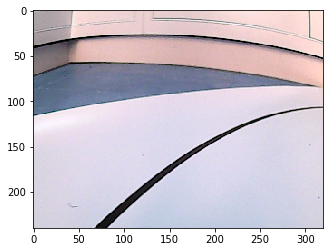

In [38]:
path_file = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/test_data/'
img = cv2.imread(path_file + str(32)+'.png')
print(compute_steering_angle(model, img))
plt.imshow(img)

In [ ]:
plt.imshow(img)
img = cv2.Canny(img, 0, 100)



In [13]:
path_file = 'C:/Users/A/Desktop/ML2 Project/machine-learning-in-science-2021/test_data/'
test_names = np.arange(1020) + 1
with open(path_file + 'test5.csv', mode='w', newline='') as submission:
    writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image_id', 'angle', 'speed'])
    for name in test_names:      
        img = cv2.imread(path_file + str(name) + '.png')
#         print(img)
        
        prediction = compute_steering_angle(model, img)
        if prediction[1] < 0.5:
            prediction[1] = 0
        else:
            prediction[1] = 1
        writer.writerow([name, prediction[0], prediction[1]])
        print(name, prediction[0], prediction[1])

NameError: name 'compute_steering_angle' is not defined